# Table of Contents

* [Data Sources](#Data-Sources)
* [Gather the Data](#Gather-the-Data)
    * [Merge Dataframes / Tables](#Merge-Dataframes-/-Tables)
* [Explore the Data](#Explore-the-Data)
    * [PoC MultiIndex Rollup Calculations Data](#PoC-MultiIndex-Rollup-Calculations-Data)
    * [Merge Movie/Category Rollups with Cleaned Movie Data](#Merge-Movie/Category-Rollups-with-Cleaned-Movie-Data)
* [Model the Data](#Model-the-Data)
* [Visualize the Results](#Visualize-the-Results)


<hr>

## Data Sources

Description of the IMDB data: https://www.imdb.com/interfaces/

IMDB Data Sources: https://datasets.imdbws.com/

<hr>

## Gather the Data

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
sns.set(rc={'figure.figsize': (12, 10), "lines.markeredgewidth": 0.5 })

In [4]:
#--------------------------------------------------------
#--  Input File 1:  name.basics.tsv
#--------------------------------------------------------
print('Reading name.basics.tsv')
nameBasics = pd.read_csv("../Data/name.basics.tsv/data.tsv", sep='\t')
print('Complete - 1 of 3')
print(nameBasics.head(5))

#--------------------------------------------------------
#--  Input File 6:  title.principals.tsv
#--------------------------------------------------------
print('Reading title.principals.tsv')
titlePrincipals = pd.read_csv("../Data/title.principals.tsv/data.tsv", sep='\t')
print('Complete - 2 of 3')
print(titlePrincipals.head(5))

#--------------------------------------------------------
#--  Input File 7:  title.ratings.tsv
#--------------------------------------------------------
print('Reading title.ratings.tsv')
titleRatings = pd.read_csv("../Data/title.ratings.tsv/data.tsv", sep='\t',dtype={"tconst": object, "averageRating": float, "numVotes": int})
print('CompletitleRatingste - 3 of 3')
print(titleRatings.head(5))

print('\n-----all data loaded -----')

Reading name.basics.tsv
Complete - 1 of 3
      nconst      primaryName birthYear deathYear  \
0  nm0000001     Fred Astaire      1899      1987   
1  nm0000002    Lauren Bacall      1924      2014   
2  nm0000003  Brigitte Bardot      1934        \N   
3  nm0000004     John Belushi      1949      1982   
4  nm0000005   Ingmar Bergman      1918      2007   

                primaryProfession                           knownForTitles  
0  soundtrack,actor,miscellaneous  tt0072308,tt0045537,tt0050419,tt0043044  
1              actress,soundtrack  tt0117057,tt0038355,tt0071877,tt0037382  
2     actress,soundtrack,producer  tt0059956,tt0054452,tt0057345,tt0049189  
3         actor,writer,soundtrack  tt0072562,tt0077975,tt0078723,tt0080455  
4           writer,director,actor  tt0050976,tt0083922,tt0060827,tt0050986  
Reading title.principals.tsv
Complete - 2 of 3
      tconst  ordering     nconst         category                      job  \
0  tt0000001         1  nm1588970             self 

### Dataset Descriptions

**name.basics.tsv.gz** - Contains the following information for names:

- nconst (string) – alphanumeric unique identifier of the name/person
- primaryName (string) – name by which the person is most often credited
- birthYear – in YYYY format
- deathYear – in YYYY format if applicable, else '\N'
- primaryProfession (array of strings) – the top-3 professions of the person
- knownForTitles (array of tconsts) – titles the person is known for


**title.principals.tsv** - Contains the principal cast/crew for titles:

- tconst (string) – alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given titleId
- nconst (string) – alphanumeric unique identifier of the name/person
- category (string) – the category of job that person was in
- job (string) – the specific job title if applicable, else '\N'
- characters (string) – the name of the character played if applicable, else '\N' 

### Merge Dataframes / Tables

In [5]:
print(len(titlePrincipals))
titlePrincipals.head(5)

29345162


,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Herself""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


In [6]:
# replace values with '\N' with the pandas 'NaN'
# source: https://stackoverflow.com/a/49406417
titlePrincipals = titlePrincipals.replace({'\\N': np.nan})

In [7]:
print(len(titlePrincipals))
titlePrincipals.head(5)

29345162


,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,NaN,"[""Herself""]"
1,tt0000001,2,nm0005690,director,NaN,NaN
2,tt0000001,3,nm0374658,cinematographer,director of photography,NaN
3,tt0000002,1,nm0721526,director,NaN,NaN
4,tt0000002,2,nm1335271,composer,NaN,NaN


In [8]:
titlePrincipals.job.unique()

array([nan, 'director of photography', 'producer', ..., 'co-creater',
       'faculty advisor', 'play "Racajda"'], dtype=object)

In [9]:
print(len(nameBasics))
nameBasics.head()

8739727


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0045537,tt0050419,tt0043044"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0038355,tt0071877,tt0037382"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,producer","tt0059956,tt0054452,tt0057345,tt0049189"
3,nm0000004,John Belushi,1949,1982,"actor,writer,soundtrack","tt0072562,tt0077975,tt0078723,tt0080455"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986"


In [10]:
# drop unused columns
nameBasics = nameBasics.drop(['knownForTitles'], axis=1)

In [11]:
# replace values with '\N' with the pandas 'NaN'
nameBasics = nameBasics.replace({'\\N': np.nan})

In [12]:
nameBasics[nameBasics.deathYear.isnull() == False].head()

,nconst,primaryName,birthYear,deathYear,primaryProfession
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack"
3,nm0000004,John Belushi,1949,1982,"actor,writer,soundtrack"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor"
5,nm0000006,Ingrid Bergman,1915,1982,"actress,soundtrack,producer"


In [13]:
nameBasics[nameBasics.deathYear.isnull() == False].index

Int64Index([      0,       1,       3,       4,       5,       6,       7,
                  8,       9,      10,
            ...
            8698619, 8698621, 8698622, 8703060, 8704749, 8705076, 8712952,
            8721585, 8721590, 8727373],
           dtype='int64', length=147760)

In [14]:
# source: https://stackoverflow.com/a/27360130
nameBasics = nameBasics.drop(nameBasics[nameBasics.deathYear.isnull() == False].index)

In [15]:
# drop unused columns
nameBasics = nameBasics.drop(['deathYear'], axis=1)

In [16]:
print(len(nameBasics))
nameBasics.head()

8591967


,nconst,primaryName,birthYear,primaryProfession
2,nm0000003,Brigitte Bardot,1934,"actress,soundtrack,producer"
12,nm0000013,Doris Day,1922,"soundtrack,actress,producer"
13,nm0000014,Olivia de Havilland,1916,"actress,soundtrack"
17,nm0000018,Kirk Douglas,1916,"actor,producer,soundtrack"
46,nm0000047,Sophia Loren,1934,"actress,soundtrack"


In [17]:
# check what rows are missing data
nameBasics.isnull().sum()

nconst                     0
primaryName                0
birthYear            8309010
primaryProfession    1515654
dtype: int64

After cleaning `titlePrincipals` and `nameBasics` individually (to save on memory allocation), we can now join both datasets.

Using a right outer join on `nameBasics` to preserve all people in the dataset.

In [18]:
# returns a left join of both dataframes
principal_data = pd.merge(titlePrincipals, nameBasics, how='right', on=['nconst'])

# Check the length of the resulting join
print(len(principal_data))

principal_data.head()

30956887


,tconst,ordering,nconst,category,job,characters,primaryName,birthYear,primaryProfession
0,tt0000001,1.0,nm1588970,self,NaN,"[""Herself""]",Carmencita,NaN,soundtrack
1,tt7513040,2.0,nm1588970,archive_footage,NaN,"[""Herself""]",Carmencita,NaN,soundtrack
2,tt0000003,2.0,nm5442194,producer,producer,NaN,Julien Pappé,NaN,producer
3,tt0000003,4.0,nm5442200,editor,NaN,NaN,Tamara Pappé,NaN,editor
4,tt0000005,1.0,nm0443482,actor,NaN,"[""Blacksmith""]",Charles Kayser,NaN,actor


In [19]:
# check what rows are missing data
principal_data.isnull().sum()

tconst                5255624
ordering              5255624
nconst                      0
category              5255624
job                  26804599
characters           17653159
primaryName                 0
birthYear            21319728
primaryProfession     2489186
dtype: int64

In [20]:
principal_data.head()

,tconst,ordering,nconst,category,job,characters,primaryName,birthYear,primaryProfession
0,tt0000001,1.0,nm1588970,self,NaN,"[""Herself""]",Carmencita,NaN,soundtrack
1,tt7513040,2.0,nm1588970,archive_footage,NaN,"[""Herself""]",Carmencita,NaN,soundtrack
2,tt0000003,2.0,nm5442194,producer,producer,NaN,Julien Pappé,NaN,producer
3,tt0000003,4.0,nm5442200,editor,NaN,NaN,Tamara Pappé,NaN,editor
4,tt0000005,1.0,nm0443482,actor,NaN,"[""Blacksmith""]",Charles Kayser,NaN,actor


Merge the data with the `titleRatings` data to get the average ratings and number of votes per movie.

In [21]:
# returns a left join of both dataframes
principal_data = pd.merge(principal_data, titleRatings, how='left', on=['tconst'])

# Check the length of the resulting join
print(len(principal_data))

principal_data.head()

30956887


,tconst,ordering,nconst,category,job,characters,primaryName,birthYear,primaryProfession,averageRating,numVotes
0,tt0000001,1.0,nm1588970,self,NaN,"[""Herself""]",Carmencita,NaN,soundtrack,5.8,1391.0
1,tt7513040,2.0,nm1588970,archive_footage,NaN,"[""Herself""]",Carmencita,NaN,soundtrack,NaN,NaN
2,tt0000003,2.0,nm5442194,producer,producer,NaN,Julien Pappé,NaN,producer,6.6,979.0
3,tt0000003,4.0,nm5442200,editor,NaN,NaN,Tamara Pappé,NaN,editor,6.6,979.0
4,tt0000005,1.0,nm0443482,actor,NaN,"[""Blacksmith""]",Charles Kayser,NaN,actor,6.2,1673.0


In [22]:
#principal_data.to_csv("../Data/principals_data.csv", sep='\t', index=False)

<hr> 

## Explore the Data

**Decision Needed:** Do we limit the analysis of cast and crew to just movies? Or do we take into account their experience on other projects such as television?

**Decision Needed:** Do we remove cast/crew that are no longer living? The goal is to decide who to hire.

In [24]:
principal_data.category.value_counts()

actor                  5889876
self                   4577486
actress                4546642
writer                 3002015
director               2826287
producer               1586137
composer                979903
cinematographer         966509
editor                  964908
production_designer     227007
archive_footage         133163
archive_sound             1330
Name: category, dtype: int64

In [25]:
principal_data.job.unique()

array([nan, 'producer', 'original idea', ...,
       'author-Kizudarake no machi-A Wounded Town', 'editor: tip-outs',
       'co-creater'], dtype=object)

In [26]:
principal_data.primaryProfession.unique()

array(['soundtrack', 'producer', 'editor', ...,
       'casting_department,art_department,costume_designer',
       'art_department,casting_department,editorial_department',
       'casting_department,assistant,producer'], dtype=object)

Will focus analysis based off of the `category` column. The `job` column appears to have many variations of the categories. It may be used to further refine the final set if needed.

In [27]:
principal_data.nconst.describe()

count      30956887
unique      8591967
top       nm0251041
freq          12715
Name: nconst, dtype: object

In [28]:
# Sort the data by actor then by the category
principal_data = principal_data.sort_values(by=['nconst', 'category'])

In [29]:
principal_data.head()

,tconst,ordering,nconst,category,job,characters,primaryName,birthYear,primaryProfession,averageRating,numVotes
251056,tt0044881,1.0,nm0000003,actress,NaN,"[""Manina""]",Brigitte Bardot,1934,"actress,soundtrack,producer",5.5,214.0
251057,tt0046200,3.0,nm0000003,actress,NaN,"[""Domino""]",Brigitte Bardot,1934,"actress,soundtrack,producer",5.4,27.0
251058,tt0047607,1.0,nm0000003,actress,NaN,"[""Anna""]",Brigitte Bardot,1934,"actress,soundtrack,producer",6.2,41.0
251059,tt0048001,3.0,nm0000003,actress,NaN,"[""Hélène Colbert""]",Brigitte Bardot,1934,"actress,soundtrack,producer",5.8,678.0
251060,tt0048103,2.0,nm0000003,actress,NaN,"[""Sophie Dimater""]",Brigitte Bardot,1934,"actress,soundtrack,producer",5.2,96.0


Need to rollup data so that there is one unique row per person, `nconst`, per `category` (there seem to be too many variations on `job`). For each row it will summarize their `averageRating`, `max`, `min`, `numMovies`, `stdDev`, and `numVotes`. This will tell us how many movies they participated in and their average ranking in that role overall based on ratings.

Above analysis could be completed by creating a dataframe that is [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/advanced.html) where the outer level is `tconst` and the second level is based on `nconst`. Somthing similar to below:

| nconst | category | avgs |
| ------ | -------- | ---- |
| nm0251041 | director | 123 |
| | producer | 567 |
| nm5442200 | editor | 891 |
| | writer | 543 |

In [30]:
columns = ['tconst', 'nconst', 'category', 'averageRating', 'numVotes']

principal_subset = pd.DataFrame(principal_data[columns]).copy(deep=True)

In [45]:
# get the row count
principal_subset['nconst'].count()

30956887

In [31]:
# source: https://www.datacamp.com/community/tutorials/pandas-multi-index
# uniquely identify the rows by creating a MultiIndex
ncategory_data = principal_subset.set_index(['nconst', 'category'])

ncategory_data.head()

tconst  averageRating  numVotes
nconst    category                                    
nm0000003 actress   tt0044881            5.5     214.0
          actress   tt0046200            5.4      27.0
          actress   tt0047607            6.2      41.0
          actress   tt0048001            5.8     678.0
          actress   tt0048103            5.2      96.0

The [`.agg()`](pandas.pydata.org/pandas-docs/stable/groupby.html#applying-multiple-functions-at-once) function docs. Usage of [Aggregating with multiple functions](pandas.pydata.org/pandas-docs/stable/basics.html#aggregating-with-multiple-functions).

A useful guide on [Summarising, Aggregating, and Grouping data in Python Pandas](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/).

In [32]:
# calculate the mean, sum, and std by group
# source: https://stackoverflow.com/a/19385591
ncategory_rollup = ncategory_data.groupby(['nconst', 'category']).agg([np.mean, 'median', np.std, 'count'])

ncategory_rollup.head(10)

averageRating                            numVotes  \
                                   mean median       std count         mean   
nconst    category                                                            
nm0000003 actress              5.940541   5.80  0.733886    37  1508.918919   
          archive_footage      6.250000   6.80  1.839423    24   310.583333   
          self                 6.600000   6.90  1.287925    17    43.235294   
nm0000013 actress              6.750000   6.80  0.761364   170   868.764706   
          archive_footage      6.736364   7.20  1.785650    11    28.363636   
          self                 6.925000   6.95  1.300513    16    35.500000   
nm0000014 actress              6.830769   6.90  0.684145    52  2778.673077   
          archive_footage      7.920000   7.70  1.327403     5    60.400000   
          self                 7.784211   8.40  2.107464    19    95.421053   
nm0000018 actor                6.693182   6.70  0.913097    88  6451.079545   

                                                       
                           median           std count  
nconst    category                                     
nm0000003 actress           378.0   3927.183606    37  
          archive_footage    36.0    789.400318    24  
          self               24.0     46.200013    17  
nm0000013 actress            11.0   4035.806056   170  
          archive_footage    13.0     26.845010    11  
          self               23.5     35.447614    16  
nm0000014 actress           837.0   6264.044655    52  
          archive_footage    49.0     35.767304     5  
          self               58.0    121.315619    19  
nm0000018 actor            1357.0  19562.332684    88

In [33]:
#ncategory_data.to_csv("../Data/principals_ncategory_data.csv", sep='\t', index=False)

Rollup by movie and category

In [47]:
# uniquely identify the rows by creating a MultiIndex
tcat_data = principal_subset.set_index(['tconst', 'category'])

tcat_data.head()

,,nconst,averageRating,numVotes
tconst,category,,,
tt0044881,actress,nm0000003,5.5,214.0
tt0046200,actress,nm0000003,5.4,27.0
tt0047607,actress,nm0000003,6.2,41.0
tt0048001,actress,nm0000003,5.8,678.0
tt0048103,actress,nm0000003,5.2,96.0


In [48]:
# calculate the mean, sum, and std by group
# source: https://stackoverflow.com/a/19385591
tcat_rollup = principal_subset.groupby(['tconst', 'category']).agg([np.mean, 'median', np.std, 'count'])

tcat_rollup.head(10)

averageRating                   numVotes                   
                            mean median  std count     mean  median  std count
tconst    category                                                            
tt0000001 self               5.8    5.8  NaN     1   1391.0  1391.0  NaN     1
tt0000003 editor             6.6    6.6  NaN     1    979.0   979.0  NaN     1
          producer           6.6    6.6  NaN     1    979.0   979.0  NaN     1
tt0000005 actor              6.2    6.2  0.0     2   1673.0  1673.0  0.0     2
tt0000011 actor              5.4    5.4  NaN     1    206.0   206.0  NaN     1
tt0000012 self               7.4    7.4  0.0     4   8337.0  8337.0  0.0     4
tt0000014 actor              7.2    7.2  0.0     2   3637.0  3637.0  0.0     2
tt0000016 self               5.9    5.9  NaN     1    946.0   946.0  NaN     1
tt0000017 actor              4.8    4.8  NaN     1    192.0   192.0  NaN     1
          actress            4.8    4.8  NaN     1    192.0   192.0  NaN     1

<hr>
### PoC MultiIndex Rollup Calculations Data

_POC data for calculating rollups using Pandas methods only. See the "MultiIndex Group Aggregation PoC.ipynb" notebook for full PoC._

Uncomment all three lines in the below block to save an updated data file to run the PoC notebook.

In [36]:
#columns = ['tconst', 'nconst', 'category', 'averageRating', 'numVotes']

#test = pd.DataFrame(principal_data[columns])[1:300].copy(deep=True)

#test.to_csv("./PoC/principals_sample_data.csv", sep='\t', index=False)

_End POC_

<hr>

### Merge Movie/Category Rollups with Cleaned Movie Data

Next merge with movie data to get the movie's year

In [46]:
# load the tab-delimited csv file
movie_data_years = pd.read_csv('../Data/movie_data_years.csv', sep='\t')

In [49]:
# returns a right join of both dataframes
principal_movie = pd.merge(principal_subset, movie_data_years, how='right', on=['tconst'])

# Check the length of the resulting join
print(len(principal_movie))

principal_movie.head()

1255744


,tconst,nconst,category,averageRating,numVotes,startYear
0,tt0208054,nm0000003,archive_footage,7.1,9.0,1987
1,tt0208054,nm0000013,archive_footage,7.1,9.0,1987
2,tt0208054,nm0001012,archive_footage,7.1,9.0,1987
3,tt0208054,nm0203015,editor,7.1,9.0,1987
4,tt0208054,nm0346767,editor,7.1,9.0,1987


In [127]:
print("movie_data_years dimensions: {}".format(movie_data_years.shape))
print("principal_subset dimensions: {}".format(principal_subset.shape))
print("principal_movie dimensions: {}".format(principal_movie.shape))

movie_data_years dimensions: (153128, 2)
principal_subset dimensions: (30956887, 5)
principal_movie dimensions: (1255744, 6)


In [99]:
# check what rows are missing data
principal_movie.isnull().sum()

tconst             0
nconst           466
category         466
averageRating    466
numVotes         466
startYear          0
dtype: int64

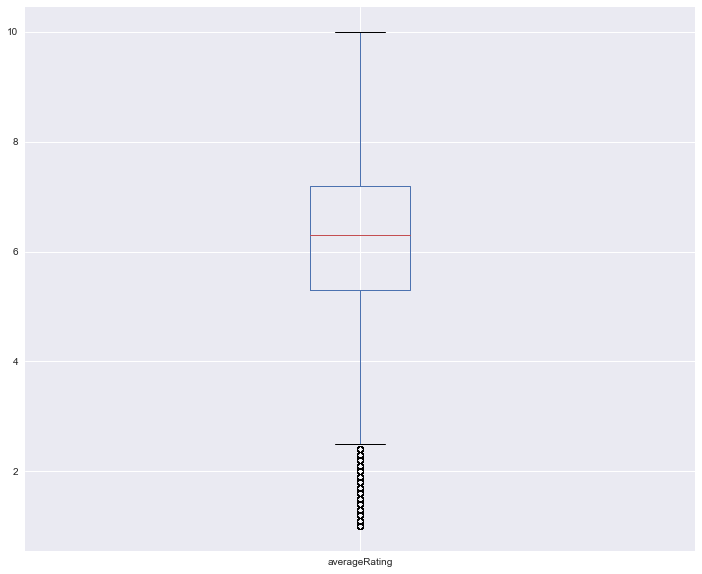

In [120]:
principal_movie.averageRating.plot(kind='box')

In [50]:
# uniquely identify the rows by creating a MultiIndex
tcat_pmovie_data = principal_movie.set_index(['tconst', 'category'])

tcat_pmovie_data.head()

nconst  averageRating  numVotes  startYear
tconst    category                                                      
tt0208054 archive_footage  nm0000003            7.1       9.0       1987
          archive_footage  nm0000013            7.1       9.0       1987
          archive_footage  nm0001012            7.1       9.0       1987
          editor           nm0203015            7.1       9.0       1987
          editor           nm0346767            7.1       9.0       1987

In [51]:
# calculate the mean, sum, and std by group
tcat_pmovie_rollup = tcat_pmovie_data.groupby(['tconst', 'category']).agg([np.mean, 'median', np.std, 'count'])

tcat_pmovie_rollup.head(10)

averageRating                   numVotes           \
                                   mean median  std count     mean   median   
tconst    category                                                            
tt0015724 actor                     6.4    6.4  NaN     1     18.0     18.0   
          actress                   6.4    6.4  0.0     2     18.0     18.0   
          cinematographer           6.4    6.4  NaN     1     18.0     18.0   
          composer                  6.4    6.4  NaN     1     18.0     18.0   
          director                  6.4    6.4  NaN     1     18.0     18.0   
          editor                    6.4    6.4  NaN     1     18.0     18.0   
          producer                  6.4    6.4  NaN     1     18.0     18.0   
          writer                    6.4    6.4  NaN     1     18.0     18.0   
tt0023331 producer                  6.8    6.8  NaN     1     66.0     66.0   
tt0035423 actor                     6.4    6.4  0.0     3  71496.0  71496.0   

                                     startYear                    
                           std count      mean median  std count  
tconst    category                                                
tt0015724 actor            NaN     1      1993   1993  NaN     1  
          actress          0.0     2      1993   1993  0.0     2  
          cinematographer  NaN     1      1993   1993  NaN     1  
          composer         NaN     1      1993   1993  NaN     1  
          director         NaN     1      1993   1993  NaN     1  
          editor           NaN     1      1993   1993  NaN     1  
          producer         NaN     1      1993   1993  NaN     1  
          writer           NaN     1      1993   1993  NaN     1  
tt0023331 producer         NaN     1      1983   1983  NaN     1  
tt0035423 actor            0.0     3      2001   2001  0.0     3

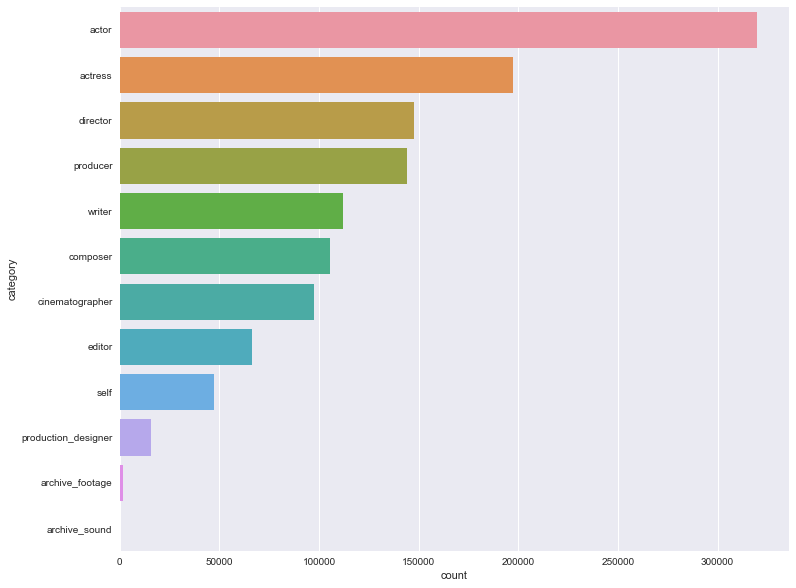

In [59]:
# visualize how many of each category is represented in the subset
sns.countplot(y=principal_movie.category,
             order=principal_movie.category.value_counts().index)

In [86]:
# mean ratings for each category
mean_ratings_by_category = principal_movie.groupby(['category']).mean()

# sort by ratings
mean_ratings_by_category.sort_values(by=['averageRating'], inplace=True, ascending=False)

In [87]:
mean_ratings_by_category

,averageRating,numVotes,startYear
category,,,
self,7.273152,462.205488,2009.022745
archive_sound,7.233333,273.833333,2014.166667
archive_footage,6.939650,1151.573384,2007.850493
editor,6.378137,2101.664265,2004.785238
cinematographer,6.315785,2363.449359,2004.632016
director,6.287069,4344.505213,2005.664926
composer,6.220629,3303.937314,2004.690320
producer,6.200341,7035.297132,2006.596930
production_designer,6.115149,2548.580928,2003.790273


Reference for further formating Seaborn charts: [Python Seaborn Tutorial For Beginners](https://www.datacamp.com/community/tutorials/seaborn-python-tutorial)

In [115]:
mean_ratings_by_category = mean_ratings_by_category.reset_index()

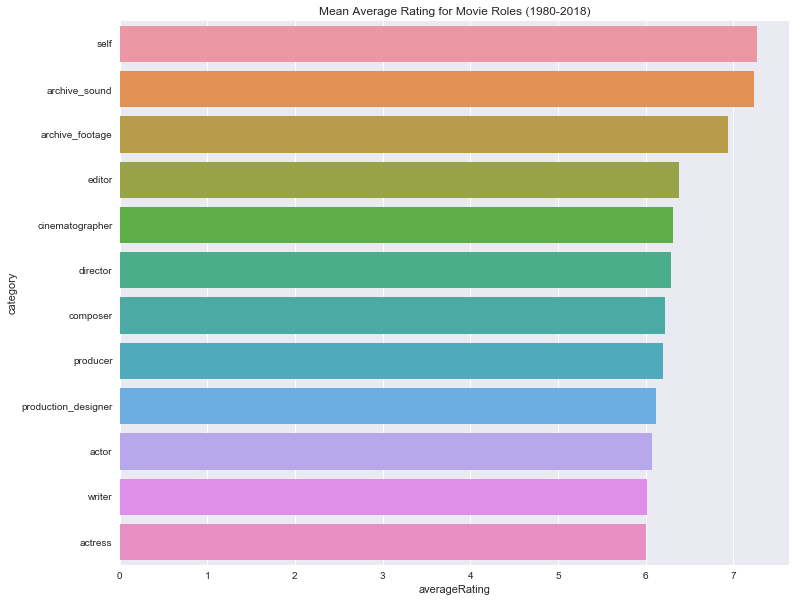

In [101]:
plot = sns.barplot(x=mean_ratings_by_category.averageRating, y=mean_ratings_by_category.index)

plot.set_title('Mean Average Rating for Movie Roles (1980-2018)')

plt.show()

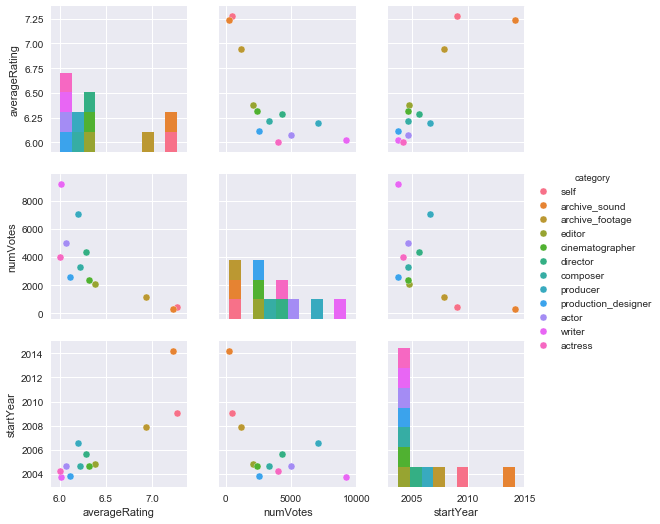

In [116]:
sns.pairplot(mean_ratings_by_category, hue='category')

In [117]:
# reset the index to category
mean_ratings_by_category = mean_ratings_by_category.set_index(['category'])

# drop rows
mean_ratings_by_category = mean_ratings_by_category.drop(['self', 'archive_sound', 'archive_footage'], axis=0)

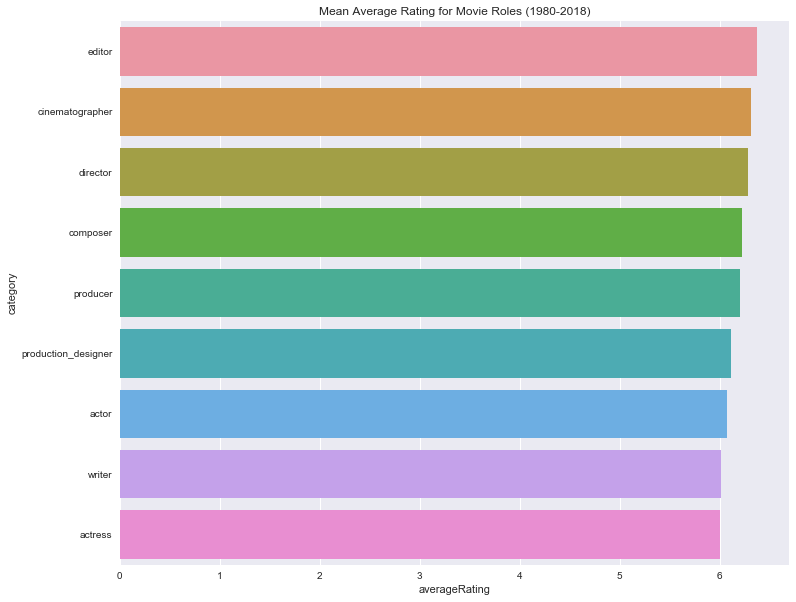

In [119]:
plot = sns.barplot(x=mean_ratings_by_category.averageRating, y=mean_ratings_by_category.index)

plot.set_title('Mean Average Rating for Movie Roles (1980-2018)')

plt.show()

<hr> 

## Model the Data

<hr> 

## Visualize the Results